### 0. Import libraries and load data

In [45]:
import os
import sys
import json
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.utils as image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, Conv2DTranspose

DATA_PATH = "../data/"
ENCODED_DATA_PATH = "../encoded_data/"
DATABASE_PATH = "database/database_lite.json"
QUERY_PATH = "query/query_lite.json"
SIMILARITY_FILE_NAME = "london_lite_gt.h5"


In [46]:
# load database data
with open(DATA_PATH + DATABASE_PATH, "r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])

# load query data
with open(DATA_PATH + QUERY_PATH, "r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    
# load relevance judgements
with h5py.File(DATA_PATH + SIMILARITY_FILE_NAME, "r") as f:
    sim = f["sim"][:].astype(np.uint8)


### 1. Pre-process images

In [47]:
def get_image_shapes(image_paths):
    """
    It returns the set of shapes of images loaded from the path given.
    """
    
    image_shapes = set()

    # create the set of image shapes
    for image_path in image_paths:
        img = plt.imread(os.path.join(DATA_PATH + image_path))
        image_shapes.add(img.shape)
        
    return image_shapes


In [48]:
def get_smallest_image_size(m_imgs_shapes, q_imgs_shapes):
    """
    This function finds the smallest image shape across the database and query images.
    Additionally, it adjusts the width and height so that they are divisible with 16.
    It represents a requirement for our architecture of the Convolutional Autoencoder.
    """

    smallest_shape = None
    smallest_size = sys.maxsize
    imgs_shapes = q_imgs_shapes.union(m_imgs_shapes)

    # find the smalles image shape
    for img_shape in imgs_shapes:
        image_size = img_shape[0] * img_shape[1] * img_shape[2]

        if image_size <= smallest_size:
            smallest_size = image_size
            smallest_shape = img_shape
            
    new_even_dims = []

    # adjust the found shape for the Convolutional Autoencoder
    for dim_index in range(len(smallest_shape) - 1):
        if smallest_shape[dim_index] % 8 == 1:
            new_even_dims.append(smallest_shape[dim_index] - smallest_shape[dim_index] % 8)
        else:
            new_even_dims.append(smallest_shape[dim_index])

    smallest_shape_even = (new_even_dims[0], new_even_dims[1], smallest_shape[2])
    print(f"\nSmallest image shape with even sizes is: {smallest_shape_even}")

    return smallest_shape_even


In [49]:
# get image shapes of database images
m_imgs_shapes = get_image_shapes(m_imgs)
print(f"Shapes of database images:\n{m_imgs_shapes}")

# get image shapes of query images
q_imgs_shapes = get_image_shapes(q_imgs)
print(f"\nShapes of query images:\n{q_imgs_shapes}")

# get the image shape that will be used throughout the project
smallest_image_shape = get_smallest_image_size(m_imgs_shapes, q_imgs_shapes)


Shapes of database images:
{(256, 455, 3), (256, 341, 3), (256, 367, 3)}

Shapes of query images:
{(256, 341, 3), (256, 455, 3)}

Smallest image shape with even sizes is: (256, 336, 3)


In [50]:
def load_images(image_paths, image_size):
    """
    It loads the images, downsample them and scale pixel values between 0 and 1.
    """

    # set a placeholder for images
    preprocessed_images = np.zeros(
        (len(image_paths), image_size[0], image_size[1], image_size[2])
    )

    for index, image_path in enumerate(image_paths):
        # preprocess each image
        raw_img = image.load_img(DATA_PATH + image_path)
        resized_img = tf.image.resize(raw_img, (image_size[0], image_size[1]))
        scaled_img = resized_img / 255
        array_img = image.img_to_array(scaled_img).astype("float32")
        preprocessed_images[index] = array_img
        
    return preprocessed_images


In [51]:
# load and preprocess database images
database_images = load_images(m_imgs, smallest_image_shape)
print(f"Shape of database dataset: {database_images.shape}")


# load and preprocess query images
query_images = load_images(q_imgs, smallest_image_shape)
print(f"Shape of query dataset: {query_images.shape}")


Shape of database dataset: (1000, 256, 336, 3)
Shape of query dataset: (500, 256, 336, 3)


In [52]:
def display_reshaped_image(database_images, m_imgs, image_index):
    """
    This function displays the original image with index image_index and its resized version.
    """

    fig, ax = plt.subplots(2, 1)
    fig.tight_layout()

    ax[0].imshow(plt.imread(os.path.join(DATA_PATH + m_imgs[image_index])))
    ax[0].set_title("Original image")

    ax[1].imshow(database_images[image_index])
    ax[1].set_title("Resized image")

    plt.show()


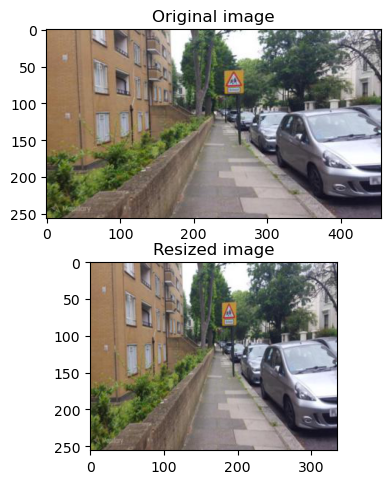

In [53]:
# display one original image and its resized version
display_reshaped_image(database_images, m_imgs, image_index=6)


### 2. Optimize the autoencoder

In [54]:
def build_model(image_shape, learning_rate=0.001, display_architecture=False):
    """
    This function defines the architecture of the Convolutional Autoencoder, compiles the model and
    displays the architecture if requested.    
    """

    # define the layers of the encoder
    input_layer = Input(shape=image_shape)   
    conv_1 = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
    conv_2 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(conv_1)
    conv_3 = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(conv_2)
    bootleneck = Conv2D(38, (3, 3), activation='relu', padding='same', strides=2)(conv_3)

    # define the layers of the dencoder
    conv_t_1 = Conv2DTranspose(38, kernel_size=3, strides=2, activation='relu', padding='same')(bootleneck)
    conv_t_2 = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_1)
    conv_t_3 = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_2)
    conv_t_4 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_3)
    output_layer = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv_t_4)

    # define autoencoder and encoder objects
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=bootleneck)   

    # compile the model
    autoencoder.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

    # display the layers if display_architecture is True
    if display_architecture:
        print(autoencoder.summary())

    return autoencoder, encoder

In [55]:
def plot_loss_evolution(history, batch_size, learning_rate, show_image=True, save_image=False):
    """
    It displays the training and validation loss. It can also store the plot in the results directory.
    """

    fig, _ = plt.subplots(1, 1)

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])

    plt.title(f"Loss evolution - batch size {batch_size} | learning rate {learning_rate}")
    plt.legend(["Training", "Validation"])

    if show_image:
        plt.show()

    if save_image:
        fig.savefig(f'../results/batch_size_{batch_size}_learning_rate_{learning_rate}.png', dpi=300)

    if not show_image:
        plt.close()

In [56]:
def optimize_model():
    """
    This represents the main optimization function that trains the model with various configurations of hyperparameters.
    In addition, it stores the details of each experiment in a CSV file and the plots of train and validation losses. This 
    is done so that after the optimization, the results can be compared and the best model can be re-trained on the entire 
    dataset of database images.
    """

    results = {"epochs": [], "batch size": [], "learning rate": [], "train loss": [], "val loss": []}

    # define hyperparameters
    batch_sizes = [1, 16, 32, 64, 128]
    learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

    # define the early stopping that monitors the validation loss
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # iterate over hyperparameters
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            # build and compile the model
            autoencoder, _ = build_model(smallest_image_shape, learning_rate)

            # train the model, using 10% as validation data
            history = autoencoder.fit(
                database_images,
                database_images,
                epochs=100,
                batch_size=batch_size,
                validation_split=0.1,
                shuffle=True,
                callbacks=[callback],
                verbose=2,
            )

            # generate plot and store it
            plot_loss_evolution(history, batch_size, learning_rate, show_image=False, save_image=True)

            # crate a Pandas DataFrame with various details and store it as a CSV file
            results["epochs"].append(len(history.history["loss"]))
            results["batch size"].append(batch_size)
            results["learning rate"].append(learning_rate)
            results["train loss"].append(history.history["loss"][-1])
            results["val loss"].append(history.history["val_loss"][-1])

            pd.DataFrame(results).to_csv("./results/optimization_results.csv", index=None)

In [57]:
# This function was executed once and the results are evaluated in the cells below.
# optimize_model()

### 3. Re-train the best autoencoder on all database images

In [58]:
# laod the CSV file that contains the optimization results
optimization_results = pd.read_csv("../results/optimization_results.csv").sort_values("val loss")
optimization_results

,epochs,batch size,learning rate,train loss,val loss
1,50,1,0.0005,0.001568,0.001794
2,25,1,0.0010,0.001916,0.002271
8,40,16,0.0050,0.002688,0.002875
0,38,1,0.0001,0.002781,0.003443
6,57,16,0.0005,0.003353,0.003956
12,41,32,0.0010,0.003499,0.004058
3,13,1,0.0050,0.004036,0.004352
11,58,32,0.0005,0.004053,0.005277
7,19,16,0.0010,0.005207,0.006104
14,22,32,0.0100,0.005521,0.006164


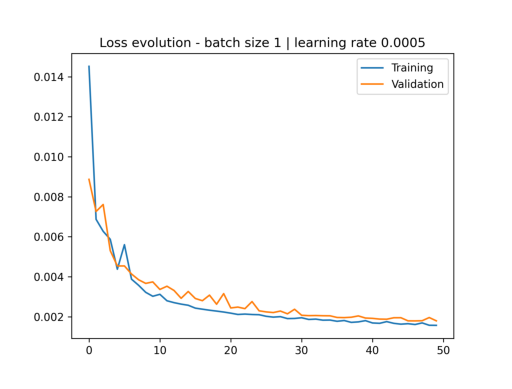

In [59]:
# get the hyperparameters of the model with the lowest validation loss
epochs_number = int(optimization_results.iloc[0, 0])
optimum_batch_size = int(optimization_results.iloc[0, 1])
optimum_learning_rate = optimization_results.iloc[0, 2]

# load and display the loss evolution of this model
loss_evolution = plt.imread(f"../results/batch_size_{optimum_batch_size}_learning_rate_{optimum_learning_rate}.png")

fig = plt.imshow(loss_evolution)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [60]:
# build the model that uses the optimal found learning rate 
autoencoder, encoder = build_model(smallest_image_shape, learning_rate=optimum_learning_rate, display_architecture=True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 336, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 168, 8)       224       
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 84, 16)        1168      
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 42, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 21, 38)        10982     
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 32, 42, 38)        13034     
 Transpose)                                                      
                                                           

In [61]:
# re-train model on the entire train set using the best hyperparameters
history = autoencoder.fit(database_images, database_images, epochs=epochs_number, batch_size=optimum_batch_size)

Epoch 1/50
1000/1000 [==============================] - 77s 74ms/step - loss: 0.0145
Epoch 2/50
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0067
Epoch 3/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0057
Epoch 4/50
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0046
Epoch 5/50
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0038
Epoch 6/50
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0036
Epoch 7/50
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0033
Epoch 8/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0032
Epoch 9/50
1000/1000 [==============================] - 60s 60ms/step - loss: 0.0030
Epoch 10/50
1000/1000 [==============================] - 62s 62ms/step - loss: 0.0029
Epoch 11/50
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0028
Epoch 12/50
1000/1000 [==============================] - 62s 62

### 4. Visualize reconstructed images

In [62]:
def display_reconstructed_images(autoencoder, database_images, query_images):
    """
    This function displays for train and validation sets three random pairs of original and reconstructed images. 
    """

    fig, ax = plt.subplots(3, 4)
    fig.set_size_inches(18, 9)

    for i in range(3):
        database_image_index = random.randint(0, len(database_images) - 1)
        original_databse_image = database_images[database_image_index]
        reconstructed_database_image = autoencoder.predict(np.array([original_databse_image]), verbose=0)[0]

        ax[i][0].imshow(original_databse_image)
        ax[i][1].imshow(reconstructed_database_image)

        if i == 0:
            ax[i][0].set_title("Original\ndatabase")
            ax[i][1].set_title("Reconstructed\ndatabase")

        query_image_index = random.randint(0, len(query_images) - 1)
        original_query_image = query_images[query_image_index]
        reconstructed_query_image = autoencoder.predict(np.array([original_query_image]), verbose=0)[0]

        ax[i][2].imshow(original_query_image)
        ax[i][3].imshow(reconstructed_query_image)

        if i == 0:
            ax[i][2].set_title("Original\nquery")
            ax[i][3].set_title("Reconstructed\nquery")

    plt.show()

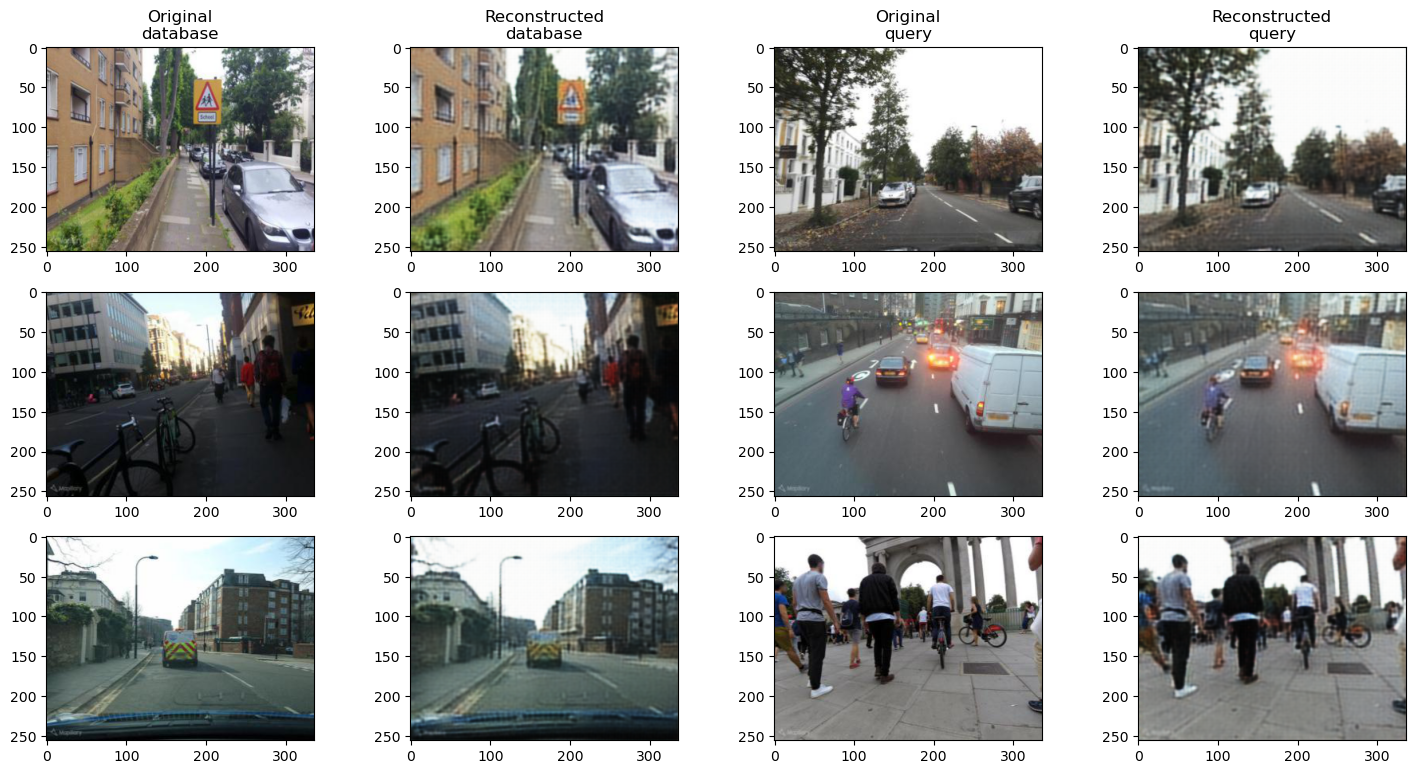

In [63]:
display_reconstructed_images(autoencoder, database_images, query_images)

### 5. Encode images and store encodings

In [64]:
def store_encoded_images(encoder, images, dataset_name):
    """
    It encodes the given set of images and stores their encodings.
    """

    images_no = images.shape[0]
    encoded_images = encoder.predict(images).reshape(images_no, -1)

    print(f"Storing encoded {dataset_name} images. Dataset size: {encoded_images.shape}\n")

    with open(ENCODED_DATA_PATH + dataset_name + "_encoded.npy", "wb") as f:
        np.save(f, encoded_images)

In [65]:
# encode and store database and query images
store_encoded_images(encoder, database_images, "database_lite")
store_encoded_images(encoder, query_images, "query_lite")

32/32 [==============================] - 1s 41ms/step
Storing encoded database_lite images. Dataset size: (1000, 12768)

16/16 [==============================] - 1s 43ms/step
Storing encoded query_lite images. Dataset size: (500, 12768)



### 6. Load encoded images

In [66]:
def load_encoded_images(dataset_name):
    """
    This function loads the encoded images of the specified data set.
    """

    print(f"Loading encoded {dataset_name} images")

    with open(ENCODED_DATA_PATH + dataset_name + "_encoded.npy", "rb") as f:
        encoded_images = np.load(f)  

    return encoded_images

In [67]:
# load encoded database and query images
encoded_database_images = load_encoded_images("database_lite")
encoded_query_images = load_encoded_images("query_lite")

Loading encoded database_lite images
Loading encoded query_lite images
